# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "4g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "4")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!hdfs dfs -copyFromLocal ../../../data .

copyFromLocal: `data/.DS_Store': File exists
copyFromLocal: `data/ml-25m/README.txt': File exists
copyFromLocal: `data/ml-25m/genome-scores.csv': File exists
copyFromLocal: `data/ml-25m/genome-tags.csv': File exists
copyFromLocal: `data/ml-25m/links.csv': File exists
copyFromLocal: `data/ml-25m/ml-25m-README.htm': File exists
copyFromLocal: `data/ml-25m/movies.csv': File exists
copyFromLocal: `data/ml-25m/ratings.csv': File exists
copyFromLocal: `data/ml-25m/tags.csv': File exists
copyFromLocal: `data/ml-25m/tmdb.json': File exists


In [5]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2021-02-17 09:52 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-17 09:52 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-17 09:52 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-17 09:52 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-17 09:52 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2021-02-17 09:52 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-17 09:52 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-17 09:52 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-17 09:52 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [6]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [7]:
ratings = sc.textFile(RATINGS_PATH)

In [8]:
%%time
ratings.take(5)

CPU times: user 7.87 ms, sys: 2.67 ms, total: 10.5 ms
Wall time: 1.6 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [9]:
ratings.getNumPartitions()

5

In [10]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [11]:
ratings.count()

25000095

Количество пользователей

In [12]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 15.7 ms, sys: 4.52 ms, total: 20.2 ms
Wall time: 44.7 s


162541

Сохраним датасет в память

In [13]:
ratings = ratings.persist()

In [14]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 18.2 ms, sys: 6.04 ms, total: 24.3 ms
Wall time: 1min 12s


162541

Количество фильмов

In [15]:
%%time

ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

CPU times: user 12.1 ms, sys: 3.81 ms, total: 16 ms
Wall time: 20.1 s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [16]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

In [17]:
movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda rating: rating[0] / rating[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196959, (5.0, ['196959', 'I Am JFK Jr. (2016)'])),
 (180663, (5.0, ['180663', '"Goodbye'])),
 (147966, (5.0, ['147966', "Tarzan's Fight for Life (1958)"])),
 (131628, (5.0, ['131628', 'Loaded (2014)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (188573, (5.0, ['188573', 'Judy (2014)'])),
 (164787, (5.0, ['164787', 'You Cast A Spell On Me (2015)'])),
 (132321, (5.0, ['132321', 'Black Oak Conspiracy (1977)'])),
 (165221, (5.0, ['165221', 'Elf Bowling the Movie (2007)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [18]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [19]:
!hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-17 13:01 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      58903 2021-02-17 13:01 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112361 2021-02-17 13:01 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131524 2021-02-17 13:01 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114377 2021-02-17 13:01 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133576 2021-02-17 13:01 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117783 2021-02-17 13:01 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143242 2021-02-17 13:01 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     131984 2021-02-17 13:01 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167729 2021-02-17 13:01 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [20]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [21]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [22]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

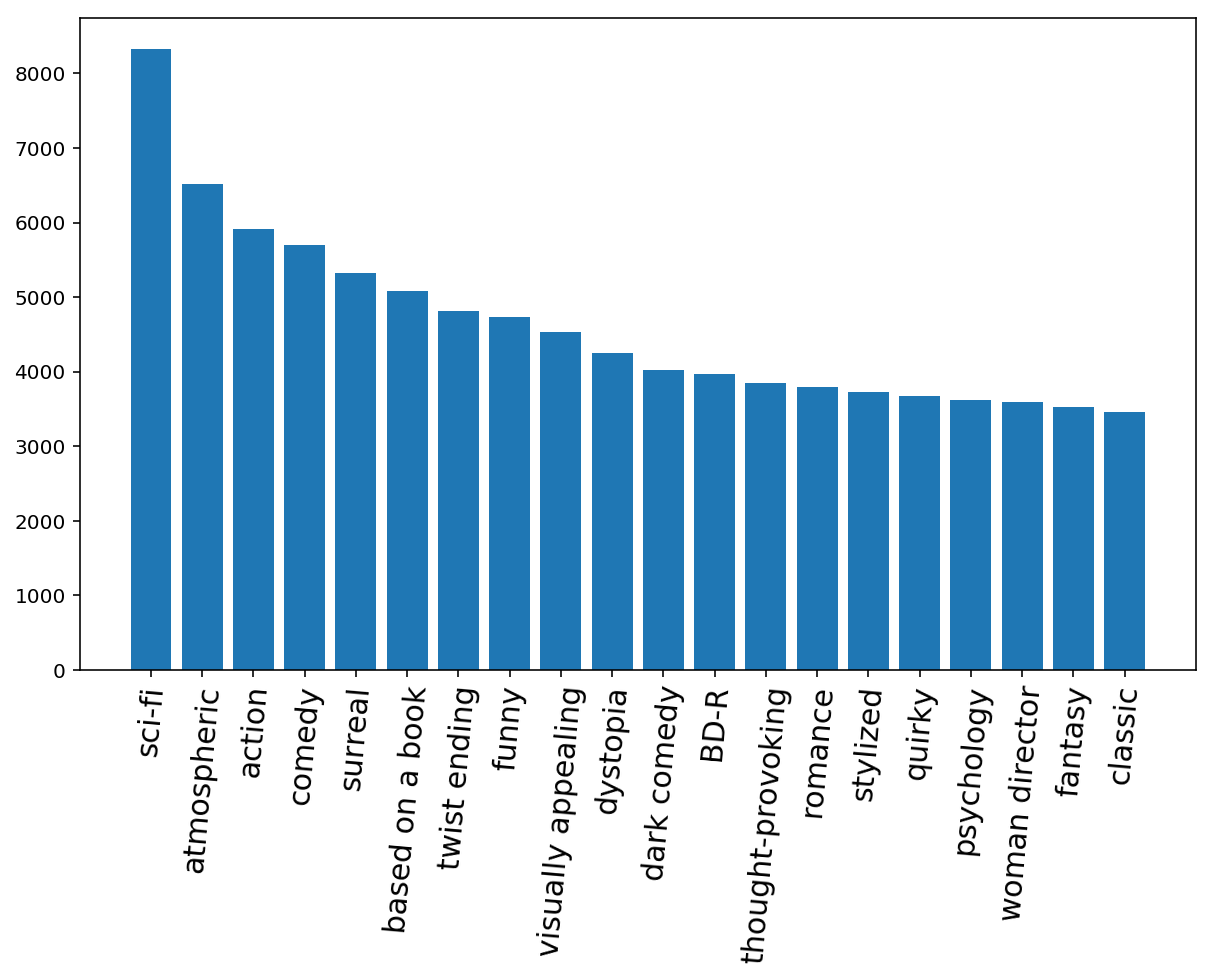

In [23]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

## Код студента (мой)

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [24]:
movies = sc.textFile(MOVIES_PATH)
movies = (
    movies
    .map(lambda s: s.split(','))
    .filter(lambda arr: arr[0].isdigit())
    .map(lambda movie: Movie(int(movie[0]), ",".join(movie[1:-1]), movie[-1]))
    .keyBy(lambda m: m.movie_id)
)

In [25]:
movies_ratings_count = (
    ratings
    .map(lambda r: (r.movie_id, 1))
    .reduceByKey(lambda x, y: x + y)
)

In [26]:
(
    movies
    .join(movies_ratings_count)
    .sortBy(lambda m: m[1][1], ascending=False)
    .map(lambda m: (m[1][0].title, m[1][1]))
    .take(10)
)

[('Forrest Gump (1994)', 81491),
 ('"Shawshank Redemption, The (1994)"', 81482),
 ('Pulp Fiction (1994)', 79672),
 ('"Silence of the Lambs, The (1991)"', 74127),
 ('"Matrix, The (1999)"', 72674),
 ('Star Wars: Episode IV - A New Hope (1977)', 68717),
 ('Jurassic Park (1993)', 64144),
 ("Schindler's List (1993)", 60411),
 ('Braveheart (1995)', 59184),
 ('Fight Club (1999)', 58773)]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [27]:
movies_fives_count = (
    ratings
    .filter(lambda r: r.rating == 5)
    .map(lambda r: (r.movie_id, 1))
    .reduceByKey(lambda x, y: x + y)
)

In [28]:
(
    movies
    .join(movies_fives_count)
    .sortBy(lambda m: m[1][1], ascending=False)
    .map(lambda m: (m[1][0].title, m[1][1]))
    .take(10)
)

[('"Shawshank Redemption, The (1994)"', 39553),
 ('Pulp Fiction (1994)', 32169),
 ('Forrest Gump (1994)', 25918),
 ('Star Wars: Episode IV - A New Hope (1977)', 25804),
 ('"Matrix, The (1999)"', 25482),
 ("Schindler's List (1993)", 24853),
 ('"Silence of the Lambs, The (1991)"', 24801),
 ('"Godfather, The (1972)"', 24418),
 ('"Usual Suspects, The (1995)"', 21585),
 ('Fight Club (1999)', 21486)]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [29]:
movie_avg_rating = (
    ratings
    .map(lambda r: (r.movie_id, (r.rating, 1)))
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
    .mapValues(lambda rating: rating[0] / rating[1])
    .collect()
)

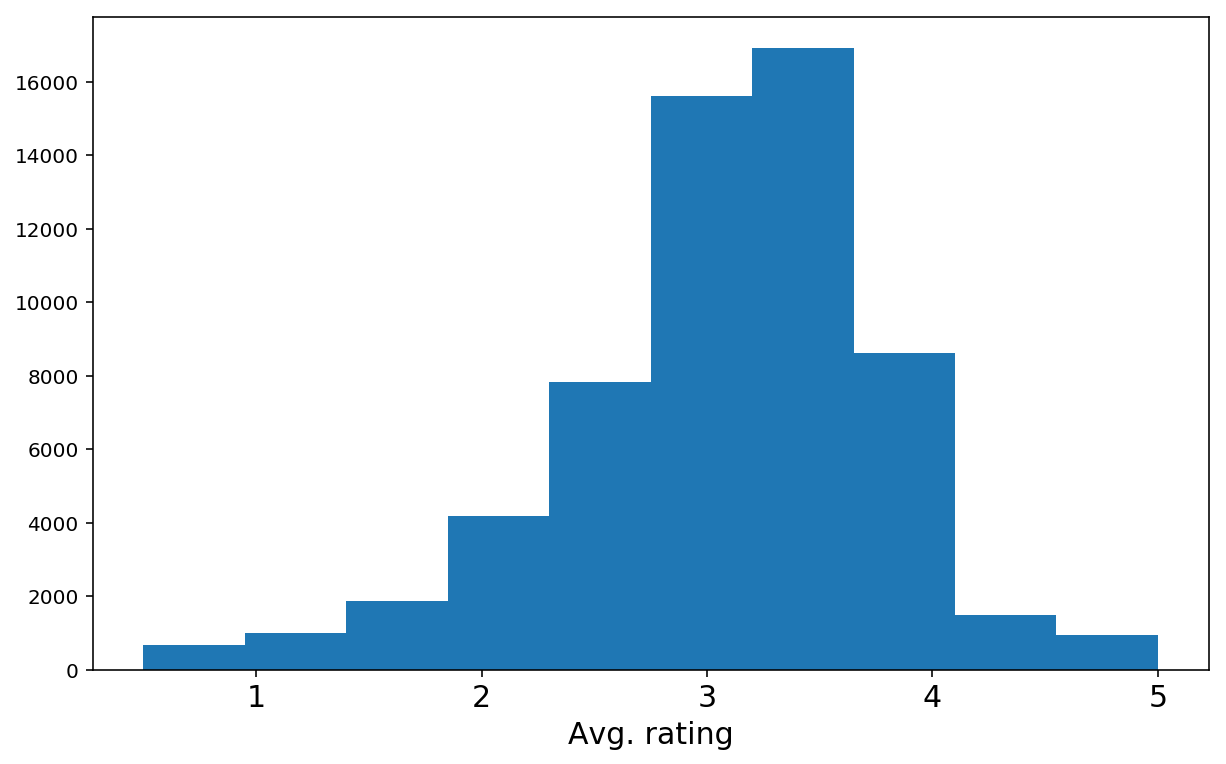

In [30]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(fontsize=15)
plt.xlabel("Avg. rating", fontsize=15)
plt.hist([r[1] for r in movie_avg_rating])
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

In [31]:
movies_rating_cnt = (
    ratings
    .map(lambda r: (r.movie_id, 1))
    .reduceByKey(lambda x, y: x + y)
    .collect()
)

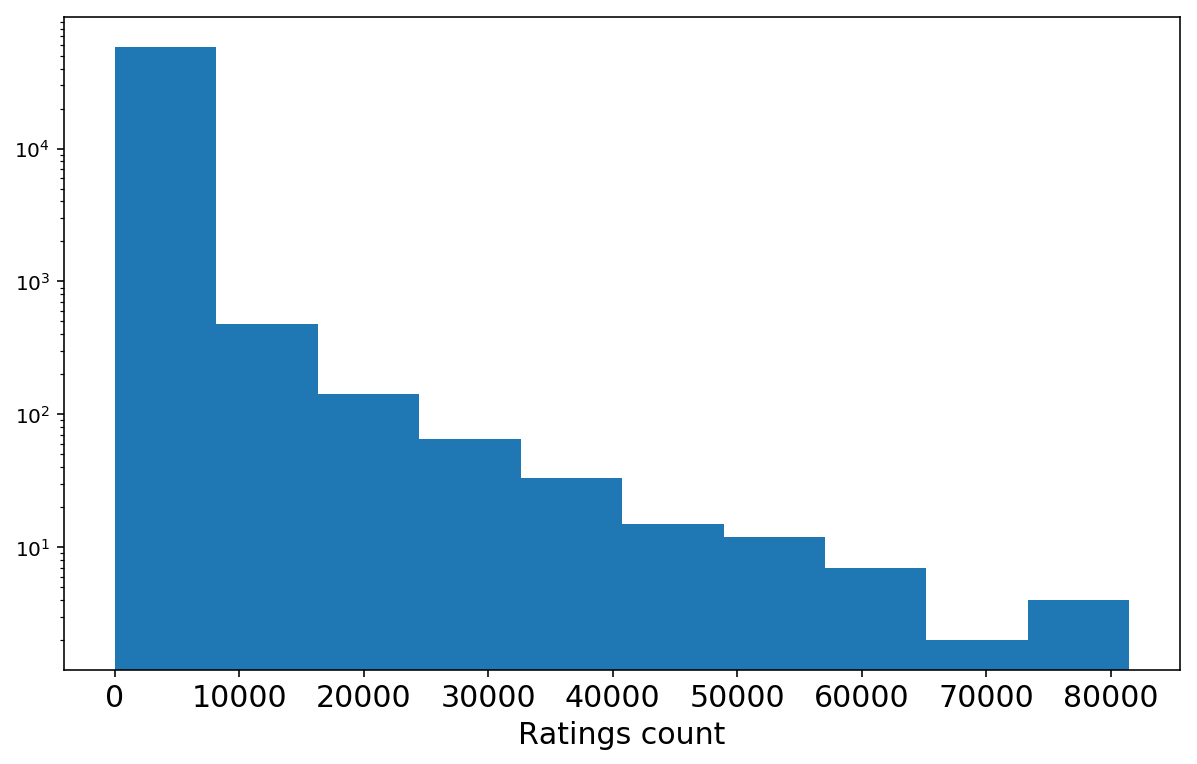

In [32]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(fontsize=15)
plt.xlabel("Ratings count", fontsize=15)
plt.hist([r[1] for r in movies_rating_cnt], log=True)
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [33]:
genres_count = (
    movies
    .flatMap(lambda m: [(g, 1) for g in m[1].genres.split("|")])
    .reduceByKey(lambda x, y: x + y)
    .collect()
)

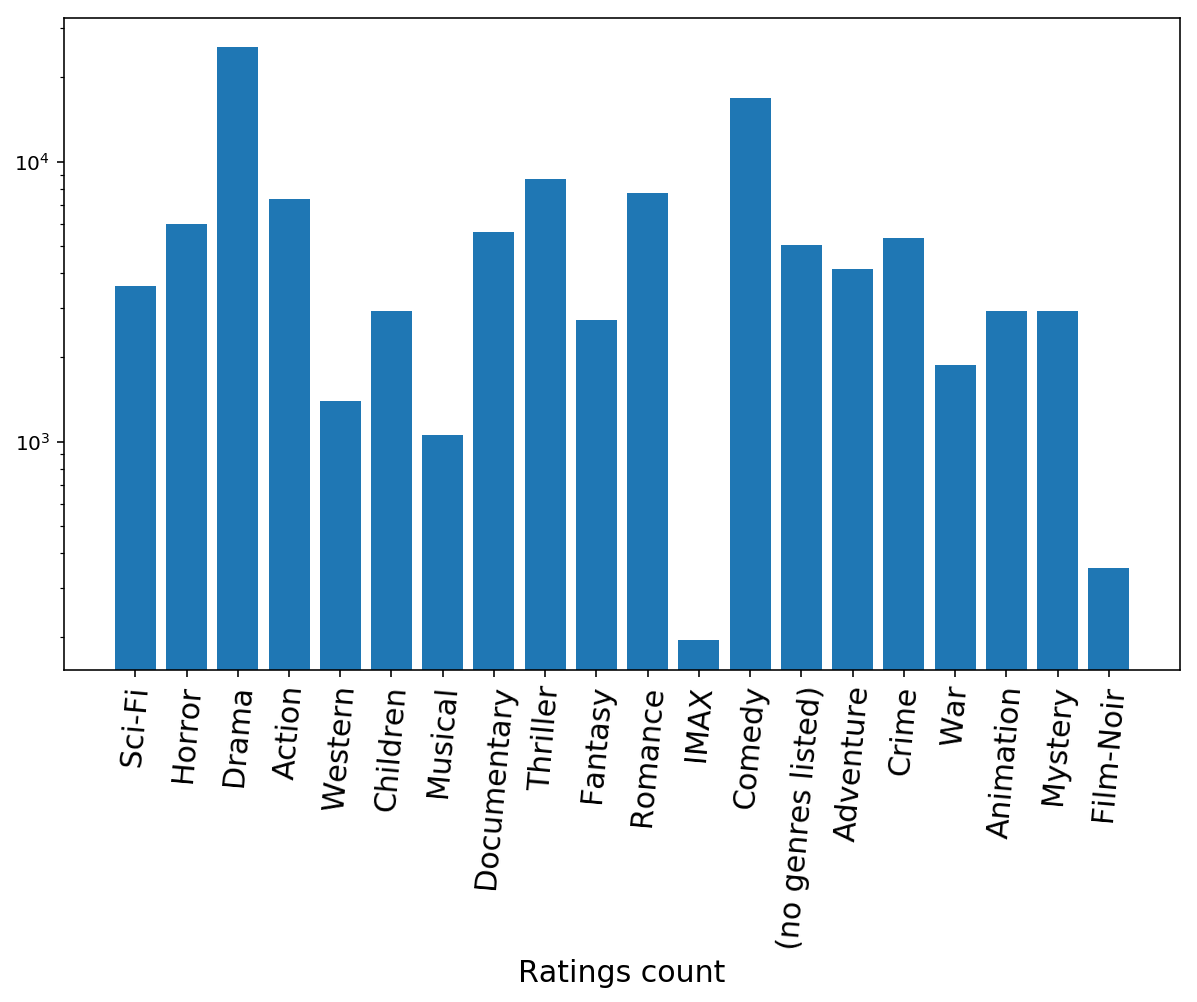

In [34]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.xlabel("Ratings count", fontsize=15)
plt.bar(*zip(*genres_count), log=True)
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [35]:
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')

In [36]:
links = sc.textFile(LINKS_PATH)
links = (
    links
    .map(lambda line: line.split(","))
    .filter(lambda row: row[0].isdigit() and row[2].isdigit())
    .map(lambda row: dict(zip(("movieId", "tmdbId"), (int(row[0]), int(row[2])))))
)

In [37]:
tmdb = sqlContext.read.json(TMDB_PATH).rdd

Фильмы с Томом Хэнксом:

In [38]:
(
    tmdb
    .filter(lambda db: db.casts is not None)
    .flatMap(lambda db: ((db.id, cast.id) for cast in db.casts.cast))
    .filter(lambda row: row[1] == 31)
    .join(
        links.keyBy(lambda link: link["tmdbId"])
    )
    .keyBy(lambda tup: tup[1][1]["movieId"])
    .join(movies)
    .map(lambda movie: movie[1][1].title)
    .collect()
)

['Sleepless in Seattle (1993)',
 '"Celluloid Closet, The (1995)"',
 'Elvis Has Left the Building (2004)',
 '"\'burbs, The (1989)"',
 'Splash (1984)',
 'Every Time We Say Goodbye (1986)',
 '"League of Their Own, A (1992)"',
 'Captain Phillips (2013)',
 'Toy Story of Terror (2013)',
 'Shooting War (2000)',
 'Killing Lincoln (2013)',
 'Toy Story (1995)',
 'And the Oscar Goes To... (2014)',
 'Bonfire of the Vanities (1990)',
 'Punchline (1988)',
 'Turner & Hooch (1989)',
 '"Simpsons Movie, The (2007)"',
 'Larry Crowne (2011)',
 'Magnificent Desolation: Walking on the Moon (2005)',
 'Toy Story Toons: Small Fry (2011)',
 '"Man with One Red Shoe, The (1985)"',
 'Toy Story 3 (2010)',
 'Sully (2016)',
 'Mazes and Monsters (1982)',
 'The Post (2017)',
 '"Money Pit, The (1986)"',
 "You've Got Mail (1998)",
 'Toy Story 4 (2019)',
 'California Typewriter (2017)',
 'Radio Flyer (1992)',
 'Apollo 13 (1995)',
 '"Pixar Story, The (2007)"',
 'Nothing in Common (1986)',
 'Angels & Demons (2009)',
 '"The 

Топ 10 по количеству фильмов актеров:

In [39]:
(
    tmdb
    .filter(lambda db: db.casts is not None)
    .flatMap(lambda db: ((cast.id, (cast.name, 1)) for cast in db.casts.cast))
    .reduceByKey(lambda x, y: (x[0], x[1] + y[1]))
    .sortBy(lambda row: row[1][1], ascending=False)
    .map(lambda row: row[1])
    .take(10)
)

[('Bess Flowers', 380),
 ('Frank Welker', 184),
 ('Christopher Lee', 175),
 ('Clarence Nash', 158),
 ('Irving Bacon', 152),
 ('John Carradine', 146),
 ('John Wayne', 142),
 ('Mel Blanc', 140),
 ('Samuel L. Jackson', 134),
 ('Eric Roberts', 130)]

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [40]:
genre_counters = (
    tmdb
    .filter(lambda db: db.release_date is not None)
    .map(lambda db: (db.id, db.release_date.split("-")[0]))
    .filter(lambda row: row[1].isdigit())
    .map(lambda row: (row[0], int(row[1])))
    .join(
        links.keyBy(lambda link: link["tmdbId"])
    )
    .keyBy(lambda tup: tup[1][1]["movieId"])
    .join(movies)
    .flatMap(lambda tup: ((tup[1][0][1][0], Counter([genre])) for genre in tup[1][1].genres.split("|")))
    .reduceByKey(lambda x, y: x + y)
    .collect()
)

In [41]:
genre_counters = sorted(genre_counters, key=lambda x: x[0])

years = [year for year, cntr in genre_counters]
genres = set(sum((cntr for year, cntr in genre_counters), Counter()))

genres2countlist = {
    genre: [cntr[genre] for year, cntr in genre_counters]
    for genre in genres
}

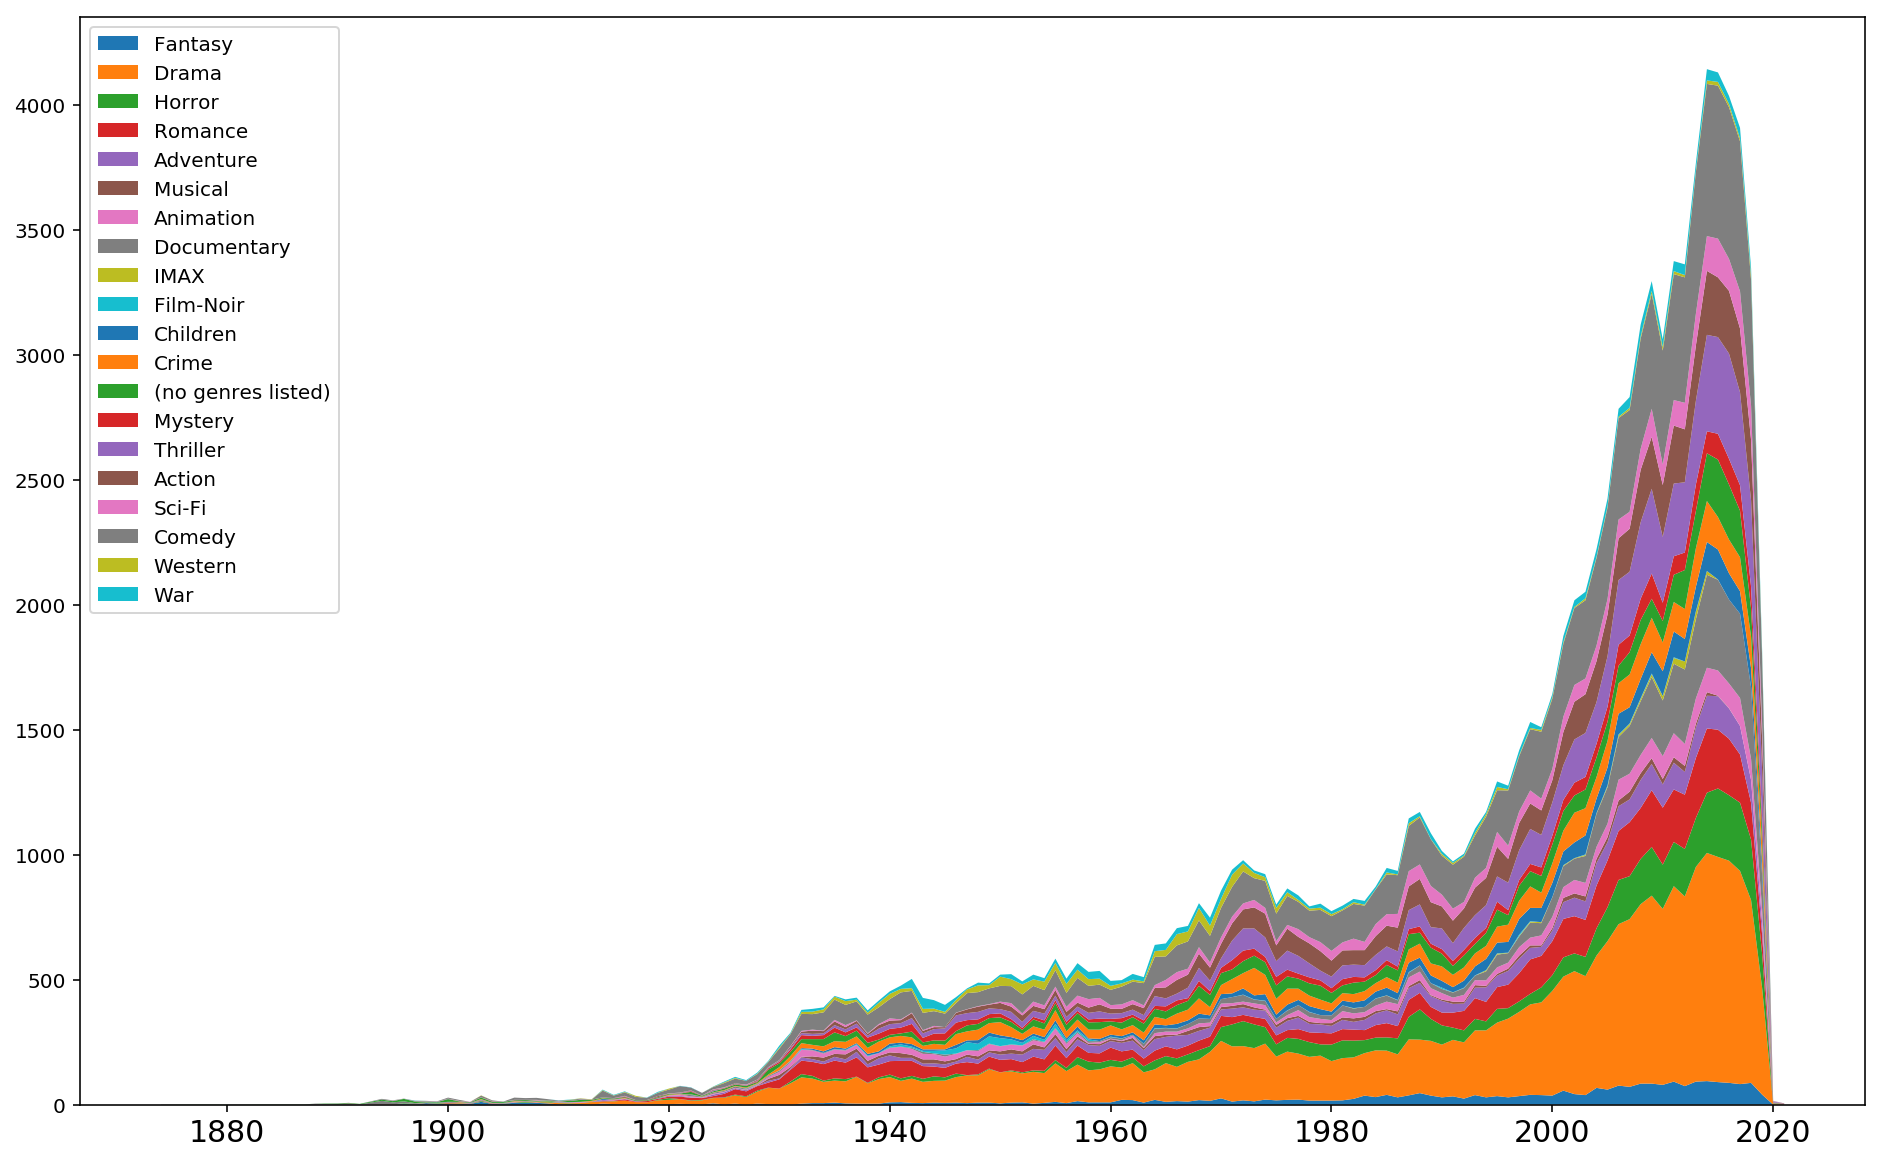

In [42]:
f, ax = plt.subplots(figsize=(16, 10))
plt.xticks(fontsize=15)
ax.stackplot(years, genres2countlist.values(),
             labels=genres2countlist.keys())
ax.legend(loc='upper left')
plt.show()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [43]:
genres_roi = (
    tmdb
    .map(lambda db: (db.id, (db.revenue, db.budget)))
    .join(
        links.keyBy(lambda link: link["tmdbId"])
    )
    .keyBy(lambda tup: tup[1][1]["movieId"])
    .join(movies)
    .flatMap(lambda tup: ((genre, tup[1][0][1][0]) for genre in tup[1][1].genres.split("|")))
    .reduceByKey(lambda x, y: tuple(x_el + y_el for x_el, y_el in zip(x, y)))
    .map(lambda tup: (tup[0], tup[1][0] / tup[1][1]))
    .collect()
)

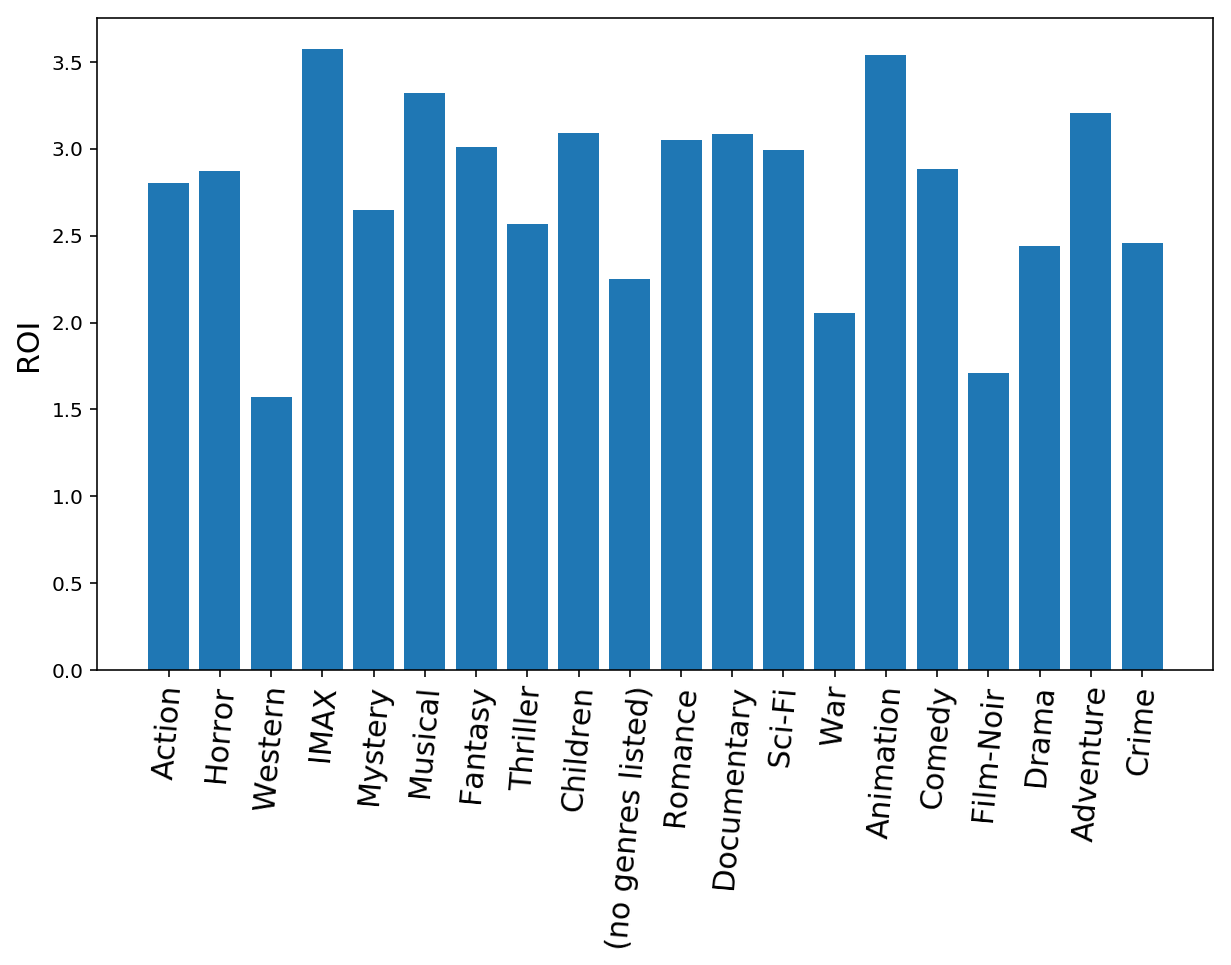

In [47]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.ylabel("ROI", fontsize=15)
plt.bar(*zip(*genres_roi))
plt.show()